Download data

In [0]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip
!ls

In [0]:
%matplotlib inline


Generating Names with a Character-Level RNN
*******************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

In the :doc:`last tutorial </intermediate/char_rnn_classification_tutorial>`
we used a RNN to classify names into their language of origin. This time
we'll turn around and generate names from languages.

::

    > python sample.py Russian RUS
    Rovakov
    Uantov
    Shavakov

    > python sample.py German GER
    Gerren
    Ereng
    Rosher

    > python sample.py Spanish SPA
    Salla
    Parer
    Allan

    > python sample.py Chinese CHI
    Chan
    Hang
    Iun

We are still hand-crafting a small RNN with a few linear layers. The big
difference is instead of predicting a category after reading in all the
letters of a name, we input a category and output one letter at a time.
Recurrently predicting characters to form language (this could also be
done with words or other higher order constructs) is often referred to
as a "language model".

**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  http://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-  `The Unreasonable Effectiveness of Recurrent Neural
   Networks <http://karpathy.github.io/2015/05/21/rnn-effectiveness/>`__
   shows a bunch of real life examples
-  `Understanding LSTM
   Networks <http://colah.github.io/posts/2015-08-Understanding-LSTMs/>`__
   is about LSTMs specifically but also informative about RNNs in
   general

I also suggest the previous tutorial, :doc:`/intermediate/char_rnn_classification_tutorial`


Preparing the Data
==================

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.

See the last tutorial for more detail of this process. In short, there
are a bunch of plain text files ``data/names/[Language].txt`` with a
name per line. We split lines into an array, convert Unicode to ASCII,
and end up with a dictionary ``{language: [names ...]}``.




In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import math
import random

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
train_data = {}
test_data = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    random.shuffle(lines)
    train_data[category] = lines[0:int(math.floor(0.8*len(lines)))]
    test_data[category] = lines[int(math.floor(0.8*len(lines)))+1:]
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['German', 'Arabic', 'Vietnamese', 'Greek', 'French', 'Scottish', 'Italian', 'Chinese', 'Korean', 'Russian', 'Dutch', 'Japanese', 'Polish', 'English', 'Irish', 'Czech', 'Spanish', 'Portuguese']
O'Neal


Creating the Network
====================

This network extends `the last tutorial's RNN <#Creating-the-Network>`__
with an extra argument for the category tensor, which is concatenated
along with the others. The category tensor is a one-hot vector just like
the letter input.

We will interpret the output as the probability of the next letter. When
sampling, the most likely output letter is used as the next input
letter.

I added a second linear layer ``o2o`` (after combining hidden and
output) to give it more muscle to work with. There's also a dropout
layer, which `randomly zeros parts of its
input <https://arxiv.org/abs/1207.0580>`__ with a given probability
(here 0.1) and is usually used to fuzz inputs to prevent overfitting.
Here we're using it towards the end of the network to purposely add some
chaos and increase sampling variety.

.. figure:: https://i.imgur.com/jzVrf7f.png
   :alt:





In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

Training
=========
Preparing for Training
----------------------

First of all, helper functions to get random pairs of (category, line):




In [0]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(train_data[category])
    return category, line

For each timestep (that is, for each letter in a training word) the
inputs of the network will be
``(category, current letter, hidden state)`` and the outputs will be
``(next letter, next hidden state)``. So for each training set, we'll
need the category, a set of input letters, and a set of output/target
letters.

Since we are predicting the next letter from the current letter for each
timestep, the letter pairs are groups of consecutive letters from the
line - e.g. for ``"ABCD<EOS>"`` we would create ("A", "B"), ("B", "C"),
("C", "D"), ("D", "EOS").

.. figure:: https://i.imgur.com/JH58tXY.png
   :alt:

The category tensor is a `one-hot
tensor <https://en.wikipedia.org/wiki/One-hot>`__ of size
``<1 x n_categories>``. When training we feed it to the network at every
timestep - this is a design choice, it could have been included as part
of initial hidden state or some other strategy.




In [0]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

For convenience during training we'll make a ``randomTrainingExample``
function that fetches a random (category, line) pair and turns them into
the required (category, input, target) tensors.




In [0]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

Training the Network
--------------------

In contrast to classification, where only the last output is used, we
are making a prediction at every step, so we are calculating loss at
every step.

The magic of autograd allows you to simply sum these losses at each step
and call backward at the end.




In [0]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_line_tensor.size(0)

To keep track of how long training takes I am adding a
``timeSince(timestamp)`` function which returns a human readable string:




In [0]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

Training is business as usual - call train a bunch of times and wait a
few minutes, printing the current time and loss every ``print_every``
examples, and keeping store of an average loss per ``plot_every`` examples
in ``all_losses`` for plotting later.




In [0]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
all_test_losses = []
total_loss = 0 # Reset every plot_every iters

# Just return an output given a line
def evaluate(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    loss = 0
    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])
    return output, loss.item() / input_line_tensor.size(0)

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0
        
    # Compute loss based on test data
    if iter % plot_every == 0:
        total_test_loss = 0
        n_test_instances = 0
        for category in all_categories:
            category_tensor = Variable(categoryTensor(category))
            n_test_instances = n_test_instances + len(test_data[category])
            for line in test_data[category]:
                input_line_tensor = Variable(inputTensor(line))
                target_line_tensor = Variable(targetTensor(line))
                output, test_loss = evaluate(category_tensor, input_line_tensor, target_line_tensor)
                total_test_loss += test_loss
        all_test_losses.append(total_test_loss / n_test_instances)
losses_i = all_test_losses


0m 54s (5000 5%) 2.9248
1m 52s (10000 10%) 2.1516
2m 51s (15000 15%) 2.2223
3m 49s (20000 20%) 2.7291
4m 47s (25000 25%) 2.8545
5m 46s (30000 30%) 2.3927
6m 45s (35000 35%) 2.4850
7m 43s (40000 40%) 1.8313
8m 42s (45000 45%) 2.5951
9m 41s (50000 50%) 2.2779
10m 39s (55000 55%) 2.5251
11m 38s (60000 60%) 2.5576
12m 36s (65000 65%) 1.6648
13m 35s (70000 70%) 2.0777
14m 33s (75000 75%) 2.1591
15m 31s (80000 80%) 2.2439
16m 30s (85000 85%) 3.6619
17m 28s (90000 90%) 2.5570
18m 27s (95000 95%) 3.2890
19m 25s (100000 100%) 2.2161


In [0]:
print(losses_i)

[3.886386448061635, 3.4052930484581485, 3.2616461479148273, 3.1974340832123045, 3.1529708077875624, 3.087221886967181, 3.063692109340834, 3.0430938567577575, 3.0195103075193273, 3.003518321686331, 2.981059779430751, 2.9699465528423667, 2.9454343753111885, 2.9540403499461885, 2.9307447773817303, 2.9174145832299088, 2.911058375085985, 2.899095613299839, 2.8819831880075912, 2.873465536427186, 2.8458255789481015, 2.837854253223292, 2.8413499704361453, 2.8338529883095003, 2.8383748821742083, 2.818917461519883, 2.818150712852068, 2.7933291791754775, 2.7996238184653275, 2.785482872060278, 2.794670377850049, 2.779964160149764, 2.7648642039955678, 2.7664263637347912, 2.755975900198877, 2.7455681355837154, 2.7523039049230635, 2.766593349086079, 2.7767144695138333, 2.723738107400511, 2.7244385817024304, 2.723351926210435, 2.7233871714370417, 2.7261371769454037, 2.718899100548081, 2.707425026582404, 2.721293627789259, 2.724887207437241, 2.6855919828063426, 2.6912506073591107, 2.689660044235257, 2.

 ii) previous hidden unit and previous character
=======

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable



class RNN_ii(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_ii, self).__init__()
        self.first = True
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        
        
        self.i2h_first = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o_first = nn.Linear(n_categories + input_size + hidden_size, output_size)
        
        
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden, first):
        if(first):
          input_combined = torch.cat((category, input, hidden), 1)
          hidden = self.i2h_first(input_combined)
          output = self.i2o_first(input_combined)
        else:
          input_combined = torch.cat((input, hidden), 1)
          hidden = self.i2h(input_combined)
          output = self.i2o(input_combined)
          
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
   

  


In [0]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor, first=False):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden, first)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        if p.grad is not None:
          p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_line_tensor.size(0)

In [0]:
rnn = RNN_ii(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
all_test_losses = []
total_loss = 0 # Reset every plot_every iters



# Just return an output given a line
def evaluate(category_tensor, input_line_tensor, target_line_tensor, first):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    loss = 0
    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden, first)
        loss += criterion(output, target_line_tensor[i])
    return output, loss.item() / input_line_tensor.size(0)
  
  
start = time.time()

for iter in range(1, n_iters + 1):
    if iter == 1:
      first = True
    else:
      first = False
    output, loss = train(*randomTrainingExample(), first)
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0
        
    # Compute loss based on test data
    if iter % plot_every == 0:
        total_test_loss = 0
        n_test_instances = 0
        for category in all_categories:
            category_tensor = Variable(categoryTensor(category))
            n_test_instances = n_test_instances + len(test_data[category])
            for line in test_data[category]:
                input_line_tensor = Variable(inputTensor(line))
                target_line_tensor = Variable(targetTensor(line))
                output, test_loss = evaluate(category_tensor, input_line_tensor, target_line_tensor, first)
                total_test_loss += test_loss
        all_test_losses.append(total_test_loss / n_test_instances)
losses_ii = all_test_losses


0m 58s (5000 5%) 2.5274
2m 1s (10000 10%) 2.4041
3m 3s (15000 15%) 2.6215
4m 6s (20000 20%) 2.9069
5m 9s (25000 25%) 2.5081
6m 11s (30000 30%) 3.3651
7m 13s (35000 35%) 3.0086
8m 14s (40000 40%) 2.6651
9m 16s (45000 45%) 3.0633
10m 18s (50000 50%) 2.5002
11m 20s (55000 55%) 2.5888
12m 22s (60000 60%) 2.8525
13m 24s (65000 65%) 2.2250
14m 26s (70000 70%) 2.8920
15m 29s (75000 75%) 1.9748
16m 31s (80000 80%) 2.4985
17m 32s (85000 85%) 3.2352
18m 35s (90000 90%) 2.8586
19m 38s (95000 95%) 2.4462
20m 40s (100000 100%) 2.2369


In [0]:
print(losses_ii)

[3.9155635083598734, 3.4512281831068927, 3.2939319060407604, 3.2135322314395305, 3.169011805853628, 3.115040113354678, 3.0937736620085445, 3.079553612303591, 3.0447682284548594, 3.0318621378922583, 2.9960637904265215, 2.9841829014409402, 2.986624266054704, 2.9620458248056636, 2.9598326928156777, 2.9515651426602316, 2.9306864270197366, 2.925913010176505, 2.939438427288945, 2.904931211256592, 2.890103663862102, 2.870732673402119, 2.9188810793110562, 2.86755052290341, 2.8892172293278877, 2.872524450467801, 2.849059688882979, 2.853743073973235, 2.8708176491580213, 2.839614342240284, 2.8406893974087755, 2.8434108249818415, 2.834900658173011, 2.822947883038495, 2.829369487828487, 2.8280787621952537, 2.823315205959706, 2.809038856561786, 2.8000060216864213, 2.794087739438045, 2.800224626570638, 2.792048794528163, 2.789921952462031, 2.792963311035348, 2.7844828746737194, 2.802974590164733, 2.7846829237745543, 2.7821023553714936, 2.7748334630347484, 2.7718183013913884, 2.766101834088194, 2.7728

 iii) previous hidden unit and category
=======

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN_iii(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(RNN_iii, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [0]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_line_tensor.size(0)

In [0]:
rnn = RNN_iii(128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
all_test_losses = []
total_loss = 0 # Reset every plot_every iters

# Just return an output given a line
def evaluate(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    loss = 0
    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])
    return output, loss.item() / input_line_tensor.size(0)

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0
        
    # Compute loss based on test data
    if iter % plot_every == 0:
        total_test_loss = 0
        n_test_instances = 0
        for category in all_categories:
            category_tensor = Variable(categoryTensor(category))
            n_test_instances = n_test_instances + len(test_data[category])
            for line in test_data[category]:
                input_line_tensor = Variable(inputTensor(line))
                target_line_tensor = Variable(targetTensor(line))
                output, test_loss = evaluate(category_tensor, input_line_tensor, target_line_tensor)
                total_test_loss += test_loss
        all_test_losses.append(total_test_loss / n_test_instances)
losses_iii = all_test_losses


0m 55s (5000 5%) 2.9456
1m 56s (10000 10%) 2.4811
2m 56s (15000 15%) 2.8507
3m 57s (20000 20%) 3.1179
4m 58s (25000 25%) 2.2576
5m 58s (30000 30%) 2.1843
6m 58s (35000 35%) 2.6640
7m 58s (40000 40%) 2.8622
8m 59s (45000 45%) 1.7537
9m 59s (50000 50%) 2.2433
11m 0s (55000 55%) 2.6926
12m 1s (60000 60%) 3.4598
13m 1s (65000 65%) 3.2126
14m 2s (70000 70%) 2.6393
15m 3s (75000 75%) 1.9738
16m 4s (80000 80%) 1.9840
17m 5s (85000 85%) 2.0691
18m 6s (90000 90%) 2.7474
19m 6s (95000 95%) 2.3727
20m 6s (100000 100%) 3.0335


In [0]:
print(losses_iii)

[3.8453732677170285, 3.3559096306442764, 3.236492629415803, 3.1728079407460763, 3.13636254738362, 3.089577094592527, 3.0708973803691904, 3.0426447364645934, 3.0333650771619465, 3.0154682277950227, 2.998505399850007, 2.9898933002357646, 2.9766558841790953, 2.9637558758954383, 2.973445088252628, 2.972374241469667, 2.939641847458568, 2.9613033503376065, 2.930768008284427, 2.911883749770709, 2.929912979095769, 2.919027649499308, 2.902641754937182, 2.917098927401331, 2.9141749552972405, 2.9145451096067774, 2.897274669086002, 2.8953672162716972, 2.889315512520405, 2.8898942313816613, 2.893511525266386, 2.88742326791271, 2.8745603940635926, 2.86572896467971, 2.8794959030917955, 2.8691967162290664, 2.8807564405668296, 2.8839499879987254, 2.8842518922694156, 2.8644973952496007, 2.978824588542679, 2.8537155804798258, 2.8687982461528025, 2.8647197944087885, 2.8549162951494527, 2.8828124925206846, 2.8504804651776903, 2.879011224836437, 2.851375066170515, 2.8507114877397193, 2.8480098763412887, 2.8

 iv) previous hidden unit
=======

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable



class RNN_iv(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(RNN_iv, self).__init__()
        self.first = True
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(hidden_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)
        
        
        self.i2h_first = nn.Linear(n_categories + hidden_size, hidden_size)
        self.i2o_first = nn.Linear(n_categories + hidden_size, output_size)
        
        
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden, first):
        if(first):
          input_combined = torch.cat((category, hidden), 1)
          hidden = self.i2h_first(input_combined)
          output = self.i2o_first(input_combined)
        else:
          input_combined = hidden
          hidden = self.i2h(input_combined)
          output = self.i2o(input_combined)
          
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
   

  


In [0]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor, first=False):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden, first)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
      if p.grad is not None:
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_line_tensor.size(0)

In [0]:
rnn = RNN_iv(128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
all_test_losses = []
total_loss = 0 # Reset every plot_every iters



# Just return an output given a line
def evaluate(category_tensor, input_line_tensor, target_line_tensor, first):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    loss = 0
    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden, first)
        loss += criterion(output, target_line_tensor[i])
    return output, loss.item() / input_line_tensor.size(0)
  
  
start = time.time()

for iter in range(1, n_iters + 1):
    if iter == 1:
      first = True
    else:
      first = False
    output, loss = train(*randomTrainingExample(), first)
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0
        
    # Compute loss based on test data
    if iter % plot_every == 0:
        total_test_loss = 0
        n_test_instances = 0
        for category in all_categories:
            category_tensor = Variable(categoryTensor(category))
            n_test_instances = n_test_instances + len(test_data[category])
            for line in test_data[category]:
                input_line_tensor = Variable(inputTensor(line))
                target_line_tensor = Variable(targetTensor(line))
                output, test_loss = evaluate(category_tensor, input_line_tensor, target_line_tensor, first)
                total_test_loss += test_loss
        all_test_losses.append(total_test_loss / n_test_instances)
losses_iv = all_test_losses


0m 53s (5000 5%) 3.7960
1m 51s (10000 10%) 2.7659
2m 49s (15000 15%) 2.6221
3m 47s (20000 20%) 2.2033
4m 45s (25000 25%) 2.3086
5m 44s (30000 30%) 2.7991
6m 42s (35000 35%) 3.2473
7m 41s (40000 40%) 2.6017
8m 39s (45000 45%) 3.2231
9m 37s (50000 50%) 3.0488
10m 38s (55000 55%) 2.7088
11m 44s (60000 60%) 3.4867
13m 39s (65000 65%) 3.1017
15m 33s (70000 70%) 2.7358
17m 26s (75000 75%) 2.5539
19m 17s (80000 80%) 3.8068
21m 9s (85000 85%) 2.5797
23m 1s (90000 90%) 3.0649
24m 54s (95000 95%) 2.5816
26m 46s (100000 100%) 2.6408


In [0]:
print(losses_iv)

[3.8239050129411774, 3.3410517568405385, 3.2225605596114657, 3.1759121639579546, 3.12555356073902, 3.1071899444134026, 3.0771155719388794, 3.0511101977973163, 3.043287485895065, 3.0382322295666433, 3.02231758767015, 2.9946697565782197, 2.999670834750144, 2.983223591294543, 2.9858906814299604, 2.9839936270449785, 2.9753813430308513, 2.9748743101215713, 2.947124238554596, 2.971360644871556, 2.9488960735487915, 2.951942278406325, 2.960500908344432, 2.941097233892984, 2.9362415088036435, 2.957734688973393, 2.9432194796542728, 2.941061883931886, 2.933247379600851, 2.953115354823776, 2.937917611463333, 2.9275582002045906, 2.9509272678189107, 2.926092880328716, 2.9250243291490516, 2.9211567763287167, 2.93140425996743, 2.936181843532154, 2.926083534218263, 2.925368798282361, 2.937762997855301, 2.920309569445663, 2.9372051655044746, 2.9289551265547793, 2.915999511656668, 2.9227995517601335, 2.9355295312729304, 2.939568836801681, 2.927017247225599, 2.920324342052235, 2.9314260209768452, 2.937389

Plotting the Losses
=======

Plotting the historical loss from all\_losses shows the network
learning:




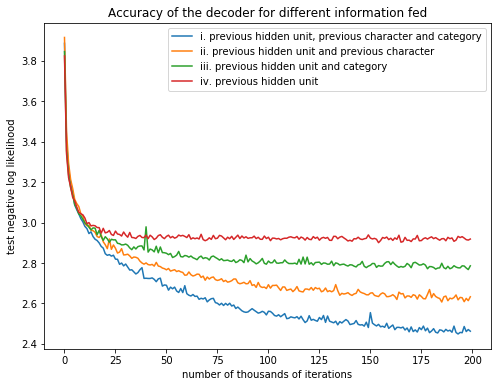

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(losses_i, label='i. previous hidden unit, previous character and category')
plt.plot(losses_ii, label='ii. previous hidden unit and previous character')
plt.plot(losses_iii, label='iii. previous hidden unit and category')
plt.plot(losses_iv, label='iv. previous hidden unit')


plt.xlabel('number of thousands of iterations')
plt.ylabel('test negative log likelihood')
plt.title('Accuracy of the decoder for different information fed')
plt.legend(loc='upper right')
plt.show()

Sampling the Network
====================

To sample we give the network a letter and ask what the next one is,
feed that in as the next letter, and repeat until the EOS token.

-  Create tensors for input category, starting letter, and empty hidden
   state
-  Create a string ``output_name`` with the starting letter
-  Up to a maximum output length,

   -  Feed the current letter to the network
   -  Get the next letter from highest output, and next hidden state
   -  If the letter is EOS, stop here
   -  If a regular letter, add to ``output_name`` and continue

-  Return the final name

.. Note::
   Rather than having to give it a starting letter, another
   strategy would have been to include a "start of string" token in
   training and have the network choose its own starting letter.




In [0]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')